In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from utilities import load_data_basic_cleanup
from transformers import Trainer, TrainingArguments, DistilBertTokenizerFast, DistilBertForSequenceClassification
from datasets import Dataset, DatasetDict
import torch
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # supress FutureWarning

## Load Data

In [2]:
# Load clean data
df = load_data_basic_cleanup()

In [3]:
# Look at topic distribution
df['TOPIC_MAIN'].value_counts()

TOPIC_MAIN
Nonfiction          31910
Fiction             30686
Children’s Books    19643
Young Adult          3749
Classics             3199
Humor                1450
Poetry               1256
Name: count, dtype: int64

In [4]:
# Ensure data is consistent
print(f"{df['TOPIC_MAIN'].value_counts().sum()} == {df.shape[0]}")

91893 == 91893


In [5]:
# Split dataset into train and test
train_df, test_df = train_test_split(df[['DESCRIPTION', 'TOPIC_MAIN']], test_size=0.2, random_state=42, shuffle=True)

In [6]:
print(train_df.shape) # (73515, 3)
print(test_df.shape) # (18379, 3)

(73514, 2)
(18379, 2)


In [7]:
train_df

,DESCRIPTION,TOPIC_MAIN
63724,"This daring, star-packed collection is the fan...",Fiction
14608,"With her soft heart and angelic face, Madeline...",Fiction
72346,NEW YORK TIMES BESTSELLER * A deeply affecting...,Nonfiction
12024,"ONE CHILL EVENING IN BETHLEHEM, young Naomi he...",Children’s Books
16203,All original stories about the return of Cthul...,Fiction
...,...,...
6265,"Following a wild and raging storm, the Swiss f...",Children’s Books
54886,A family-focused guidebook to Italy for travel...,Nonfiction
76820,A single volume of the most beautiful texts by...,Poetry
860,The Truth Chasers Book Three. Someone's trying...,Fiction


In [8]:
test_df

,DESCRIPTION,TOPIC_MAIN
62081,This lexicon of modern Western philosophical c...,Nonfiction
18176,"Emily-and her new band, the Strangers-won the ...",Children’s Books
19140,A perfect graudation gift all about growing up...,Children’s Books
16534,Even a bookish big sister is drawn in by the p...,Children’s Books
21974,Where Can You Find the Kind of Love You Truly ...,Nonfiction
...,...,...
458,"In a small, dusty town in India, Sripathi Rao ...",Fiction
25026,The Limits to Capital provides one of the best...,Nonfiction
73035,How climate change will affect our political t...,Nonfiction
43431,When a woman's body washes up on the shore of ...,Fiction


In [9]:
# Convert categorical labels (topics) to numerical values
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['TOPIC_MAIN'])
test_df['label'] = label_encoder.transform(test_df['TOPIC_MAIN'])
train_df.head()

,DESCRIPTION,TOPIC_MAIN,label
63724,"This daring, star-packed collection is the fan...",Fiction,2
14608,"With her soft heart and angelic face, Madeline...",Fiction,2
72346,NEW YORK TIMES BESTSELLER * A deeply affecting...,Nonfiction,4
12024,"ONE CHILL EVENING IN BETHLEHEM, young Naomi he...",Children’s Books,0
16203,All original stories about the return of Cthul...,Fiction,2


In [10]:
# Convert Pandas DataFrames to HuggingFace Dataset-format
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df[['DESCRIPTION', 'label']]),
    'test': Dataset.from_pandas(test_df[['DESCRIPTION', 'label']])
})
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['DESCRIPTION', 'label', '__index_level_0__'],
        num_rows: 73514
    })
    test: Dataset({
        features: ['DESCRIPTION', 'label', '__index_level_0__'],
        num_rows: 18379
    })
})


## Tokenize data

In [11]:
# Load pre-trained DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    texts = [str(text) if text is not None else "" for text in batch['DESCRIPTION']]
    # tokenize text with padding and truncate for consistent input length
    return tokenizer(texts, padding="max_length", truncation=True)

# Apply function to the dataset
dataset = dataset.map(tokenize, batched=True)

# Remove 'DESCRIPTION' column, as it's not needed after tokenization
dataset = dataset.remove_columns(['DESCRIPTION'])

# Set the format of the dataset to PyTorch tensors
dataset.set_format("torch")

## Setup Model Training

In [12]:
# Check GPU availability
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA GeForce RTX 4070 Ti is available.


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) # cuda == GPU usage

cuda


## Train model

In [14]:
# Load the pre-trained DistilBERT model for sequence classification
# + specify num_labels (number of unique topics)
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_encoder.classes_))

training_args = TrainingArguments(
    output_dir="./results", # directory where model/checkpoints are saved
    evaluation_strategy="epoch", # evaluate at the end of epoch
    save_strategy="epoch", # save model each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16, # consumes about 7GB of VRAM
    per_device_eval_batch_size=16,
    num_train_epochs=2, # 2 training epochs
    weight_decay=0.01, # weight decay to prevent overfitting
    logging_dir="./logs",
    logging_steps=10, # log each ten steps
    no_cuda=False, # force gpu usage
    fp16=True, # mixed precision to speed up training
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)

# Start training the model
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.213100,0.254216
2,0.071900,0.263516


TrainOutput(global_step=9190, training_loss=0.263821060918231, metrics={'train_runtime': 1296.8439, 'train_samples_per_second': 113.374, 'train_steps_per_second': 7.086, 'total_flos': 1.947815336080589e+16, 'train_loss': 0.263821060918231, 'epoch': 2.0})

## Evaluate model

In [15]:
# Evaluate model on test set
trainer.evaluate()

{'eval_loss': 0.2635156810283661,
 'eval_runtime': 39.384,
 'eval_samples_per_second': 466.661,
 'eval_steps_per_second': 29.174,
 'epoch': 2.0}

In [16]:
# Generate predictions on the test set
predictions = trainer.predict(dataset["test"])

# Extract the predictions and labels
preds = predictions.predictions.argmax(-1)  # Get predicted class labels
labels = predictions.label_ids # Get true labels

In [30]:
# Generate classification report
report = classification_report(labels, preds, target_names=label_encoder.classes_)  # Ensure label names are included
accuracy = accuracy_score(labels, preds)


print("Classification Report - DistillBert:\n")
print(report)
print(f"Accuracy: {accuracy:.4f}")
print("Macro F1-Score:", f1_score(labels, preds, average='macro'))

Classification Report - DistillBert:

                  precision    recall  f1-score   support

Children’s Books       0.93      0.95      0.94      3912
        Classics       0.78      0.71      0.74       648
         Fiction       0.94      0.95      0.95      6096
           Humor       0.75      0.53      0.62       272
      Nonfiction       0.95      0.96      0.96      6426
          Poetry       0.90      0.85      0.87       243
     Young Adult       0.75      0.66      0.70       782

        accuracy                           0.93     18379
       macro avg       0.86      0.80      0.82     18379
    weighted avg       0.92      0.93      0.92     18379

Accuracy: 0.9253
Macro F1-Score: 0.8247707723661984


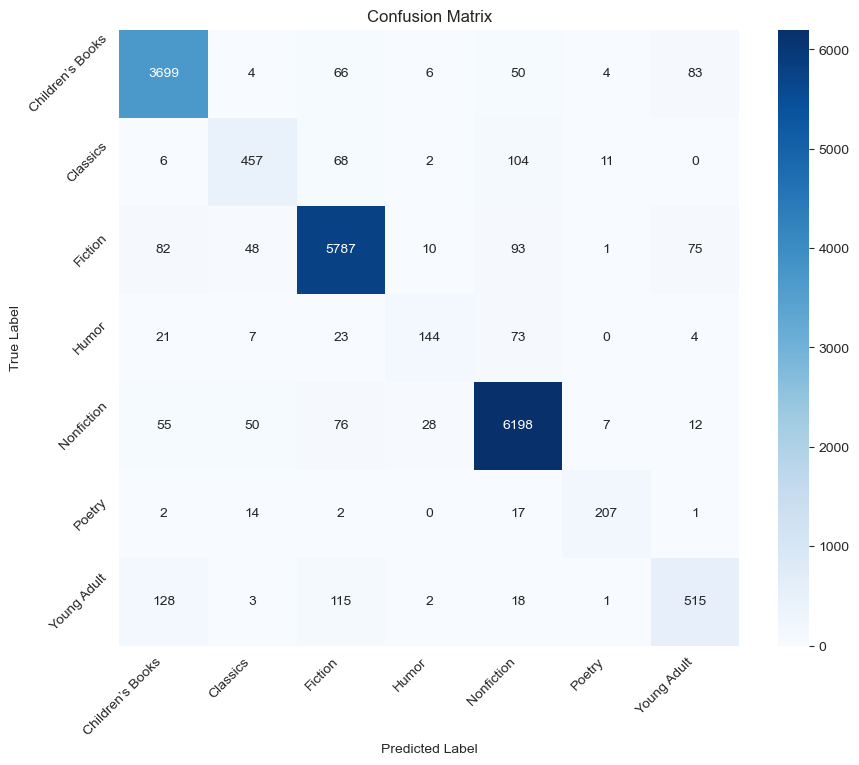

In [18]:
# Generate + Visualize ConfusionMatrix
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45)
plt.show()

In [19]:
# Save final model
model.save_pretrained("./final_model")
tokenizer.save_pretrained("./final_model")

('./final_model\\tokenizer_config.json',
 './final_model\\special_tokens_map.json',
 './final_model\\vocab.txt',
 './final_model\\added_tokens.json',
 './final_model\\tokenizer.json')

## Test trained model

In [20]:
# Load saved model
saved_model = DistilBertForSequenceClassification.from_pretrained("./final_model", num_labels=len(label_encoder.classes_))

# Load saved tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("./final_model")

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to chosen device (GPU or CPU)
saved_model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [21]:
def predict_top_3(description):
    # Tokenize the input description
    inputs = tokenizer(description, padding=True, truncation=True, return_tensors="pt")

    # Move inputs to the device (GPU or CPU)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Get the model's logits (raw prediction scores)
    with torch.no_grad():
        logits = saved_model(**inputs).logits

    # Get the top 3 predictions based on the logits (softmax to get probabilities)
    probs = torch.nn.functional.softmax(logits, dim=-1)

    # Get top 3 predictions
    top_3_values, top_3_indices = torch.topk(probs, 3, dim=-1)

    # Convert to numpy and get the predicted labels
    top_3_values = top_3_values.cpu().numpy().flatten()  # Get probabilities
    top_3_indices = top_3_indices.cpu().numpy().flatten()  # Get indices of the topics

    top_3_topics = label_encoder.inverse_transform(top_3_indices)

    return list(zip(top_3_topics, top_3_values))

## Test model prediction

In [24]:
new_description = "A thrilling adventure about a young hero discovering magic."
predicted_top_3 = predict_top_3(new_description)

print("Topics (Sorted according to similarities):")
for topic, prob in predicted_top_3:
    print(f"{topic}: {prob:.4f} %")

Topics (Sorted according to similarities):
Children’s Books: 0.9953 %
Young Adult: 0.0038 %
Fiction: 0.0004 %


In [25]:
new_description = "A thrilling adventure about a hero discovering magic."
predicted_top_3 = predict_top_3(new_description)

print("Topics (Sorted according to similarities):")
for topic, prob in predicted_top_3:
    print(f"{topic}: {prob:.4f} %")

Topics (Sorted according to similarities):
Children’s Books: 0.9962 %
Young Adult: 0.0029 %
Fiction: 0.0004 %


In [26]:
new_description = "A thrilling adventure about a hero discovering America."
predicted_top_3 = predict_top_3(new_description)

print("Topics (Sorted according to similarities):")
for topic, prob in predicted_top_3:
    print(f"{topic}: {prob:.4f} %")

Topics (Sorted according to similarities):
Children’s Books: 0.9865 %
Young Adult: 0.0112 %
Fiction: 0.0013 %


In [27]:
new_description = "A story about America."
predicted_top_3 = predict_top_3(new_description)

print("Topics (Sorted according to similarities):")
for topic, prob in predicted_top_3:
    print(f"{topic}: {prob:.4f} %")

Topics (Sorted according to similarities):
Children’s Books: 0.7398 %
Young Adult: 0.1935 %
Fiction: 0.0557 %
